In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [2]:
train_graph=nx.read_edgelist('D:/Python Assignmment/Facebook Freind Reommendation/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

DiGraph with 1780722 nodes and 7550015 edges


# Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

In [3]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [4]:
#node 1635354 not in graph 
print(jaccard_for_followees(2730,1505))

0


In [5]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [6]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## Cosine distance

In [7]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [8]:
print(cosine_for_followees(2,470294))

0.08944271909999159


In [9]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [10]:
print(cosine_for_followers(2,470294))

0.02886751345948129


## Ranking Measures
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

In [11]:
pr = nx.pagerank(train_graph, alpha=0.85)

In [12]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.709825134193587e-05
mean 5.615699699389075e-07


In [13]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


## Shortest path:
Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path.

In [14]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [15]:
compute_shortest_path_length(77697, 826021)

10

- A Strongly connected component is a sub-graph where there is a path from every node to every other node
- A weakly connected component is one in which all components are connected by some path, ignoring direction. So this entire graph would be a weakly connected component.

## Checking for same community

In [16]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [17]:
belongs_to_same_wcc(669354,1635354)

0

## Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.

In [18]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

## Does the person was follow back

In [19]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [20]:
follows_back(1,189226)

1

## Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/ Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality

In [21]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)

In [22]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [23]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [24]:
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [25]:
print('MIN',hits[0][min(hits[0], key=hits[0].get)])
print('MAX',hits[0][max(hits[0], key=hits[0].get)])
print('MEAN',float(sum(hits[0].values())) / len(hits[0]))

MIN -1.4376114543634408e-21
MAX 0.004868653379538979
MEAN 5.615699699308675e-07


## Featurization

In [26]:
import random
if not os.path.isfile('train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [27]:
if not os.path.isfile('test_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [28]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [29]:
df_final_train = pd.read_csv('D:/Python Assignmment/Facebook Freind Reommendation/data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('D:/Python Assignmment/Facebook Freind Reommendation/data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head()

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1553030,1283053,1
2,1622310,1645746,1
3,753961,1843752,1
4,785326,1006657,1


In [30]:
df_final_test = pd.read_csv('D:/Python Assignmment/Facebook Freind Reommendation/data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('D:/Python Assignmment/Facebook Freind Reommendation/data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head()

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,992327,550492,1
2,1810977,1642326,1
3,62624,262316,1
4,1703183,1755993,1


## Adding a set of features

#### we will create these each of these features for both train and test data points

- jaccard_followers
- jaccard_followees
- cosine_followers
- cosine_followees
- num_followers_s
- num_followees_s
- num_followers_d
- num_followees_d
- inter_followers
- inter_followees

In [31]:
#mapping jaccrd followers to train and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
#mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
#mapping jaccrd followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
#mapping jaccrd followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [32]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [33]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'],df_final_train['num_followees_s'], df_final_train['num_followees_d'],df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
df_final_test['num_followers_s'], df_final_test['num_followers_d'], df_final_test['num_followees_s'], df_final_test['num_followees_d'], df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

In [34]:
#mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
#mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
#mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)


#mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

#mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
#mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

## Adding new set of features
we will create these each of these features for both train and test data points

## Weight Features
- weight of incoming edges
- weight of outgoing edges
- weight of incoming edges + weight of outgoing edges
- weight of incoming edges * weight of outgoing edges
- 2*weight of incoming edges + weight of outgoing edges
- weight of incoming edges + 2*weight of outgoing edges
- Page Ranking of source
- Page Ranking of dest
- katz of source
- katz of dest
- hubs of source
- hubs of dest
- authorities_s of source
- authorities_s of dest

## Weight Features
In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. credit - Graph-based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang

In [35]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|████████████████████████████████████████████████████████████████████| 1780722/1780722 [00:12<00:00, 138786.56it/s]


In [36]:
df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

#mapping to pandas test
df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))
#some features engineerings on the in and out weights
df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

#some features engineerings on the in and out weights
df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [37]:
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))

In [38]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226340e-16,2.231877e-15
1,1553030,1283053,1,0,0.0,0.0,0.0,1,3,2,...,1.577350,1.654701,1.920836e-07,7.383663e-07,0.000735,0.000742,2.972401e-18,6.024142e-19,3.151929e-17,3.035046e-19
2,1622310,1645746,1,0,0.0,0.0,0.0,23,2,32,...,1.590990,1.060660,1.770036e-06,4.191489e-07,0.000822,0.000739,2.437843e-13,8.329992e-15,1.154664e-12,1.714436e-15
3,753961,1843752,1,0,0.0,0.0,0.0,1,1,1,...,3.000000,3.000000,4.042322e-07,6.428994e-07,0.000735,0.000735,3.077892e-25,4.764690e-18,3.346100e-20,4.288164e-23
4,785326,1006657,1,0,0.0,0.0,0.0,14,5,21,...,1.029697,0.834650,1.175733e-06,3.858586e-07,0.000787,0.000751,2.457399e-15,2.946429e-16,4.455638e-15,1.391225e-15


http://be.amazd.com/link-prediction/

## Preferential Attachment:
One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity

In [39]:
def preferential_attachment_followers(df): # function for calculating  preferential_attachment
    preferential_attachment=[] 
    preferential_attachment=df['num_followers_s']*df['num_followers_d']
    return preferential_attachment

In [40]:
df_final_train[' preferential_attachment_followers']=preferential_attachment_followers(df_final_train)
df_final_test[' preferential_attachment_followers']=preferential_attachment_followers(df_final_test)

In [41]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,preferential_attachment_followers
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226340e-16,2.231877e-15,66
1,1553030,1283053,1,0,0.0,0.0,0.0,1,3,2,...,1.654701,1.920836e-07,7.383663e-07,0.000735,0.000742,2.972401e-18,6.024142e-19,3.151929e-17,3.035046e-19,3
2,1622310,1645746,1,0,0.0,0.0,0.0,23,2,32,...,1.060660,1.770036e-06,4.191489e-07,0.000822,0.000739,2.437843e-13,8.329992e-15,1.154664e-12,1.714436e-15,46
3,753961,1843752,1,0,0.0,0.0,0.0,1,1,1,...,3.000000,4.042322e-07,6.428994e-07,0.000735,0.000735,3.077892e-25,4.764690e-18,3.346100e-20,4.288164e-23,1
4,785326,1006657,1,0,0.0,0.0,0.0,14,5,21,...,0.834650,1.175733e-06,3.858586e-07,0.000787,0.000751,2.457399e-15,2.946429e-16,4.455638e-15,1.391225e-15,70


In [42]:
def preferential_attachment_followees(df): # function for calculating  preferential_attachment
    preferential_attachment=[] 
    preferential_attachment=df['num_followees_s']*df['num_followees_d']
    return preferential_attachment

In [43]:
df_final_train[' preferential_attachment_followees']=preferential_attachment_followees(df_final_train)
df_final_test[' preferential_attachment_followees']=preferential_attachment_followees(df_final_test)

In [44]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,preferential_attachment_followers,preferential_attachment_followees
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226340e-16,2.231877e-15,66,120
1,1553030,1283053,1,0,0.0,0.0,0.0,1,3,2,...,1.920836e-07,7.383663e-07,0.000735,0.000742,2.972401e-18,6.024142e-19,3.151929e-17,3.035046e-19,3,2
2,1622310,1645746,1,0,0.0,0.0,0.0,23,2,32,...,1.770036e-06,4.191489e-07,0.000822,0.000739,2.437843e-13,8.329992e-15,1.154664e-12,1.714436e-15,46,96
3,753961,1843752,1,0,0.0,0.0,0.0,1,1,1,...,4.042322e-07,6.428994e-07,0.000735,0.000735,3.077892e-25,4.764690e-18,3.346100e-20,4.288164e-23,1,2
4,785326,1006657,1,0,0.0,0.0,0.0,14,5,21,...,1.175733e-06,3.858586e-07,0.000787,0.000751,2.457399e-15,2.946429e-16,4.455638e-15,1.391225e-15,70,105


In [45]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,preferential_attachment_followers,preferential_attachment_followees
0,848424,784690,1,0,0.000000,0.029161,0.000000,6,14,6,...,6.557971e-07,1.559547e-06,0.000754,0.000786,3.243237e-16,1.745624e-16,2.969838e-15,9.269209e-14,84,54
1,992327,550492,1,0,0.222222,0.082479,0.377964,3,7,4,...,1.188425e-06,1.546425e-06,0.000742,0.000757,4.565988e-20,7.406283e-18,2.312228e-22,6.494766e-19,21,28
2,1810977,1642326,1,0,0.000000,0.000000,0.000000,7,13,9,...,6.040773e-07,1.446579e-06,0.000759,0.000781,7.287984e-16,1.939912e-13,2.253291e-15,1.479773e-16,91,108
3,62624,262316,1,0,0.052632,0.038490,0.140028,3,15,3,...,2.811548e-07,1.131541e-06,0.000743,0.000790,3.074607e-15,4.084766e-13,2.981043e-15,2.711831e-13,45,51
4,1703183,1755993,1,0,0.000000,0.055902,0.000000,5,8,2,...,1.183879e-06,9.718901e-07,0.000750,0.000762,1.425711e-20,5.413715e-16,2.909971e-19,2.216786e-17,40,22


## Adding new set of features
we will create these each of these features for both train and test data points

SVD features for both source and destination

In [46]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [47]:
#for svd features to get feature vector creating a dict node val and index in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [48]:
len(sadj_dict)

1780722

In [49]:
Adj =nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [50]:
print(Adj)

  (0, 180907)	1.0
  (0, 301965)	1.0
  (1, 598394)	1.0
  (1, 797643)	1.0
  (1, 919667)	1.0
  (1, 1142212)	1.0
  (1, 1545223)	1.0
  (2, 169215)	1.0
  (2, 266193)	1.0
  (2, 515484)	1.0
  (2, 1207861)	1.0
  (3, 5985)	1.0
  (3, 1777903)	1.0
  (5, 1507720)	1.0
  (6, 76841)	1.0
  (6, 743869)	1.0
  (6, 1683883)	1.0
  (8, 1585129)	1.0
  (9, 547335)	1.0
  (10, 436141)	1.0
  (10, 676815)	1.0
  (10, 1190123)	1.0
  (11, 27338)	1.0
  (11, 35691)	1.0
  (11, 196996)	1.0
  :	:
  (1780716, 963620)	1.0
  (1780716, 1115404)	1.0
  (1780716, 1188206)	1.0
  (1780717, 1425478)	1.0
  (1780718, 164758)	1.0
  (1780718, 1351893)	1.0
  (1780719, 37690)	1.0
  (1780719, 190746)	1.0
  (1780719, 214157)	1.0
  (1780719, 317913)	1.0
  (1780719, 952312)	1.0
  (1780719, 1030707)	1.0
  (1780719, 1380897)	1.0
  (1780719, 1402810)	1.0
  (1780719, 1679425)	1.0
  (1780719, 1740185)	1.0
  (1780719, 1769726)	1.0
  (1780720, 539001)	1.0
  (1780720, 998332)	1.0
  (1780720, 1028930)	1.0
  (1780720, 1100093)	1.0
  (1780720, 1135303)

In [51]:
from scipy.sparse.linalg import svds, eigs
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [52]:
df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] =df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] =df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    
df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] =df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] =df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    
df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] =df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] =df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] =df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] =df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)


In [53]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       ' preferential_attachment_followers',
       ' preferential_attachment_followees', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6'],
      dtype='o

In [54]:
def NP_dot_U(df):# function product between source node and destination of svd features
    np_dot_u=[]
    for i,row in df.iterrows():
        a=svd(row['source_node'],U)
        b=svd(row['destination_node'],U)
        np_dot_u.append(np.dot(a,b))
    return np_dot_u

In [55]:
df_final_train['np_dot_u']=NP_dot_U(df_final_train)
df_final_test['np_dot_u']=NP_dot_U(df_final_test)

In [56]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,np_dot_u
0,273084,1505602,1,0,0.0,0.0,0.0,11,6,15,...,-1.545081e-13,8.108427e-13,1.719693e-14,1.355366e-12,-4.675325e-13,1.128583e-06,-6.616643e-14,9.771064e-13,4.159933e-14,1.114915e-11
1,1553030,1283053,1,0,0.0,0.0,0.0,1,3,2,...,-2.148788e-13,2.190137e-13,5.874891e-16,4.845761e-16,-2.316073e-14,1.928105e-14,-6.759727e-16,7.030249e-15,5.657677e-18,1.094252e-25
2,1622310,1645746,1,0,0.0,0.0,0.0,23,2,32,...,-3.826493e-11,3.413958e-10,2.152186e-11,4.054264e-22,-1.792510e-22,3.411138e-22,-7.398857e-22,8.573778e-22,2.444712e-22,8.441613e-18
3,753961,1843752,1,0,0.0,0.0,0.0,1,1,1,...,-1.953979e-19,4.480502e-19,6.242202e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.066760e-33
4,785326,1006657,1,0,0.0,0.0,0.0,14,5,21,...,-2.872202e-12,1.093180e-12,8.304873e-14,4.145450e-13,-1.613517e-13,5.086368e-07,-2.528563e-14,1.320862e-13,2.593113e-14,7.539604e-13


In [57]:
def NP_dot_V(df):# function product between source node and destination of svd features
    np_dot_v=[]
    for i,row in df.iterrows():
        a=svd(row['source_node'],V.T)
        b=svd(row['destination_node'],V.T)
        np_dot_v.append(np.dot(a,b))
    return np_dot_v

In [58]:
df_final_train['np_dot_v']=NP_dot_V(df_final_train)
df_final_test['np_dot_v']=NP_dot_V(df_final_test)

In [59]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,np_dot_u,np_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,11,6,15,...,8.108436e-13,1.719704e-14,1.355366e-12,-4.675315e-13,1.128586e-06,-6.616693e-14,9.771076e-13,4.160013e-14,1.114912e-11,2.238770e-12
1,901833,1416532,1,0,0.000000,0.125000,0.000000,36,32,40,...,2.172396e-14,4.145166e-05,4.864432e-16,-4.559207e-15,3.869427e-13,2.265956e-11,1.932551e-14,3.825880e-05,-6.409548e-24,1.585891e-09
2,579094,110619,1,0,0.050000,0.034360,0.096225,7,11,9,...,1.126566e-12,4.582894e-16,3.142402e-15,-3.986460e-12,5.691485e-12,-1.722264e-12,9.646153e-14,6.396681e-15,2.001676e-21,9.833261e-23
3,1190643,212431,1,0,0.000000,0.000000,0.000000,6,8,3,...,1.631047e-13,3.719701e-14,2.008314e-13,-1.006827e-13,1.071665e-13,-6.309365e-15,3.790089e-15,3.383652e-16,1.127063e-25,6.977532e-25
4,99661,62265,1,0,0.161826,0.027517,0.288265,62,240,104,...,-8.413968e-13,2.279508e-02,-1.319163e-13,6.676304e-13,-3.305846e-10,1.529819e-08,-3.385254e-12,9.355920e-02,2.911225e-03,2.132690e-03


In [65]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [61]:
df_final_train1=df_final_train.drop(['source_node','destination_node','indicator_link'],axis=1)
df_final_test1=df_final_test.drop(['source_node','destination_node','indicator_link'],axis=1)

In [66]:
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
param_dist = {"n_estimators":[10,25,50,100],
              "max_depth": [1,3,5]
            }

clf=XGBClassifier( n_jobs=-1)

rf_random=GridSearchCV(clf, param_grid=param_dist,cv=10,scoring='f1',return_train_score=True)

rf_random.fit(df_final_train1,y_train)

[18:10:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:18:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:22:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=

In [67]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.87992313 0.92695374 0.94345528 0.96385531 0.95058634 0.9717253
 0.97506012 0.97802994 0.9664317  0.97461786 0.9779043  0.9814368 ]
mean train scores [0.88046912 0.92684262 0.94364017 0.96397667 0.95049174 0.97196739
 0.97567607 0.97995541 0.96662082 0.97556401 0.98123731 0.98999857]


In [68]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [69]:
clf=rf_random.best_estimator_
clf.fit(df_final_train1,y_train)
y_train_pred = clf.predict(df_final_train1)
y_test_pred = clf.predict(df_final_test1)

[18:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [70]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.989040847749298
Test f1 score 0.9236681517768535


In [71]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)  #Recall
    
    B =(C/C.sum(axis=0))  #precision
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


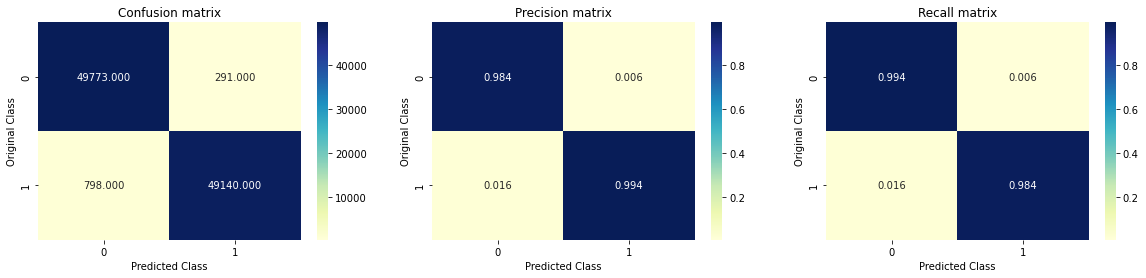

In [72]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)

Test confusion_matrix


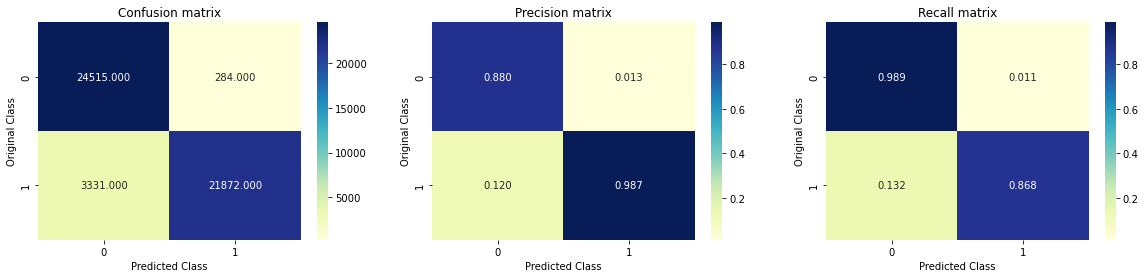

In [73]:
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)